<a href="https://colab.research.google.com/github/PCR-git/Repo1/blob/master/270C_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAE 270C - Final Project
## Optimal Control of a Rocket Launch
### Peter Racioppo

In [0]:
## Imports
import numpy as np
import math
import matplotlib.pyplot as plt

In [0]:
## System Parameters:
g = 32 # Gravitational acceleration (ft/sec^2)
T = 2*g # Constant specific thrust of the rocket
h = 320000 # Final height in ft
t0 = 0 # Start time (sec)
tf = 900 # Final time (sec)
dt = 0.01 # Time step (in diff. eq. solver)
Nt = int(tf/dt)+1 # Number of time steps
tvec = np.linspace(0,tf,Nt) # Vector of time steps
eps = 0.005 # Epsilon
spsi = np.array([10E-1,10E-1]) # Constants in the descent on δψ
it = 5 # Number of iterations in the steepest descent algorithm

In [0]:
## Initial Conditions:
## (zero displacement & velocity)
X0 = np.array([0,0,0,0])

## Final Conditions:
## (height h, zero vertical speed)
x2_f = h
x4_f = 0
psif = np.array([x2_f,x4_f])

In [0]:
## Dynamic Model:
# x1'(t) = r' = x3(t)            # Horizontal Displacement
# x2'(t) = h' = x4(t)            # Vertical Displacement
# x3'(t) = v' = T*cos[u(t)]      # Horizontal Velocity
# x4'(t) = w' = T*sin[u(t)] − g  # Vertical Velocity
# u(t) is the inclination of the rocket motor’s thrust vector to the horizontal

In [0]:
## The Performance Criterion (Cost Function):
# J(u(.),x0) = φ(x(tf)) + ∫[L(x(t),u(t),t)dt]|(t0 to tf)
# J = -x3(tf) # Cost function for this problem

In [0]:
## The Hamiltonian:
# H(x,u,λ,t) = L(x,u,t) + λf.T(x,u,t).
# H(x,u,λ,t) = λ1*x3 + λ2*x4 + λ3*T cos(u) + λ4*T sin(u) − λ4

In [0]:
## Pontryagin Conditions:
# Hu(xo(t),uo(t),λ(t),t) = 0, ∀ t in [t0, tf ]
# −λ.T(t) = Hx(xo(t),uo(t),λ(t),t)
# λ.T(tf ) = φx(xo(tf)) + ν.T*ψx(xo(tf ))

In [0]:
## Lagrange Multiplier Dynamics:
# −λ1'(t) = 0,
# −λ2'(t) = 0,
# −λ3'(t) = λ1(t)
# −λ4'(t) = λ2(t)
# λ1(tf) = 0
# λ2(tf ) = ν2
# λ3(tf ) = −1
# λ4(tf ) = ν4

## Solution of the Lagrange Multiplier Dynamic Equations:
# λ1(t) = 0
# λ2(t) = ν2
# λ3(t) = -1
# λ4(t) = ν4 + (tf − t)*ν2 for t in [t0, tf]

In [0]:
## Setting Hu = 0 and solving for u0
# Hu(x,u,λ,t) = −λ3.T*sin(u) + λ4.T*cos(u) = 0
# uo(t) = arctan[λ4(t)/λ3(t)] = arctan[−ν4 − (tf − t)*ν2] 

In [0]:
## From pg. 129 of "Primer on Optimal Control Theory" (Speyer & Jacobson):

# Consider the nonlinear dynamic equation corresponding to the
# nominal control uN(t) and the resulting path xN(t):
# xN'(t) = f(xN(t),uN(t),t)                                            (4.65)

# Consider perturbations in uN(t) as:
# uN+1(·) = uN(·) + δu(·)                                              (4.66)

# Consider the nonlinear terminal constraint ψ(x(tf)) = 0.
# Let λψ(t) be the influence function associated with the terminal constraint:
# λψ'(t) = −fx.T(xN(t),uN(t),t)*λψ(t), λψ(tf) = ψx.T(tf)               (4.68)

# The change in the terminal constraint is:
# δψ(tf) = ψx(tf)δx(tf) = λψ.T(t0)δx(t0)
#                         + ∫[λψ.T(t)*fu(xN(t),uN(t),t)δu(t)dt]        (4.69)

# The perturbed cost is:
# δJ = φx(tf)δx(tf)
#    + ∫(Lx(xN(t),uN(t),t)δx(t) + Lu(xN(t),uN(t),t)δu(t))dt             (4.70)
#    = λφ.T(t0)δx(t0)
#    + ∫[(Lu(xN(t),uN(t),t) + λφ.T(t)*fu(xN(t),uN(t),t))δu(t)dt]        (4.71)

# Consider the nonlinear terminal cost φ(x(tf)). We have:
# λφ'(t) = −fx.T(xN(t),uN(t),t)*λφ(t) − Lx.T(xN(t),uN(t),t),
# λφ(tf) = φx.T(tf)                                                    (4.72)

# Choose the control perturbation:
# δu(t) = -ε*[(λφ.T(t) + ν.T*λψ.T(t))*fu(xN(t),uN(t),t)
#             + Lu(xN(t),uN(t),t)].T                                   (4.75)

# Adjoin δψ(tf) to δJ with a Lagrange multiplier ν.
# ν = -(∫[λψ.T*fu(xN(t),uN(t),t)*fu.T(xN(t),uN(t),t)*λψ(t)dt])^-1
#   × {ψx(xN(tf))δx(tf)/ε
#   + ∫[λψ.T(t)*fu(xN(t),uN(t),t)Lu.T*(xN(t),uN(t),t)dt]
#   + ∫[λψ.T*fu(xN(t),uN(t),t)*fu.T(xN(t),uN(t),t)*λφ(t)dt]}           (4.78)

In [0]:
## ALGORITHM: Steepest Descent for Terminally Constrained Optimization Problems
# 1.) Choose the nominal control uN(t) over the interval t ∈ [t0, tf].
# 2.) Integrate (4.65) forward from the initial conditions to the
#     terminal time tf to obtain the nominal state xN(t).
#     Store the values over the trajectory.
# 3.) Integrate (4.68) & (4.72) backward from their terminal conditions to the
#     initial time t0 and store the values over the trajectory.
# 4.) Choose the desired change in the terminal constraint δψ(tf) and the
#     desired change in the cost through the choice of ε. These choices are
#     made small enough to retain the assumed linearity but large enough for
#     the algorithm to converge quickly.
# 5.) Compute ν from (4.78). The integrals in (4.78) can be computed along with
#     the influence functions obtained from (4.68) and (4.72).
# 6.) Compute the perturbation δu(t) from (4.75) and form a new nominal control
#     as given in (4.66) and repeat step 2. Check to see if the actual change
#     in the constraints and cost are close to the predicted values of the
#     perturbed constraint (4.69) and perturbed cost (4.71) based on the assumed
#     linear perturbation theory. This is where the choices of ε and δψ(tf) are
#     checked to determine if they are made small enough to retain the assumed
#     linearity but large enough for the algorithm to converge quickly.

### STEP 1:

In [0]:
## Guessing a nominal control:

# At time tf, the rocket should be nearly horizontal:
# => u(tf) = 0 = arctan[−ν4 − (tf − tf)*ν2] = arctan[−ν4]
# => ν4 = -tan(0) = 0

# On the other hand: At time tf, the rocket
# should have about zero vertical acceleration:
# => T*sin(u(tf)) = T*sin(arctan[−ν4 − (tf − tf)*ν2]) = g
# => ν4 = -tan(arcsin(1/2)) = -tan(pi/6) = -1/sqrt(3) ~ -0.58

# At time t0=0, suppose the rocket is at ui radians:
# => u(0) = ui = arctan[−ν4 − tf*ν2]
# => tan(ui) = -ν4 - tf*ν2
# => ν2 = -(tan(ui)+ν4)/tf

# Initial guess for nu4 and nu2:
nu4 = -0.35 # Guess for ν4
ui = math.pi/4.7 # Guess for initial angle
nu2 = -(np.tan(ui)+nu4)/tf # ν2
uN = np.array(np.arctan(-nu4 - (tf - tvec)*nu2)) # Nominal control

### STEP 2:

In [0]:
## Solves the system's equations of motion:
def f_DynamicSim(uN,t0,tf,g,T,dt,X0):

  Nt = int(tf/dt) + 1 # Number of time steps
  Xi = X0 # Initialize state at ith time step
  XN = np.zeros((4,Nt)) # Initialize nominal state
  XN[:,0] = X0 # Initial conditions

  i = 0 # Initialize iteration counter
  ti = t0 # Initialize time counter
  # Iterate over time interval:
  # (At final time step: i+1 = tf/dt, where i = ti/dt => ti = tf - dt)
  while ti <= tf-dt:
    
    # Update derivative using the equations of motion
    Xp = np.array([Xi[2], Xi[3], T*np.cos(uN[i]), T*np.sin(uN[i]) - g])
    Xi = Xi + Xp*dt # Update state at ith time step

    XN[:,i+1] = Xi # Update nominal state
    i += 1 # Increment counter
    ti += dt # Increment timer

  # Ouput: Nominal state
  return XN

In [0]:
# Run the dynamic model:
XN = f_DynamicSim(uN,t0,tf,g,T,dt,X0)
Xfc = np.array([XN[1,-1],XN[3,-1]]) # Final states
# print(XN)
# print(Xfc)

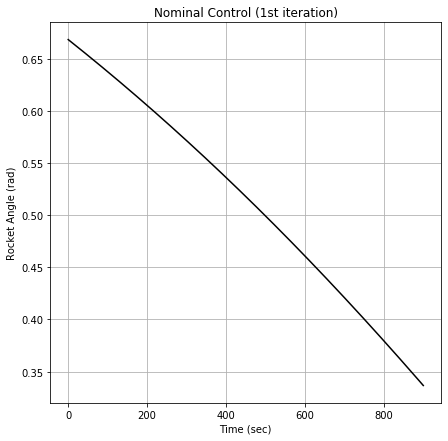

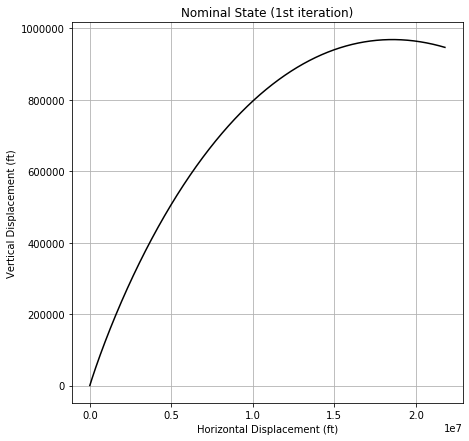

Final height = 947005.247 ft
Final upward speed = -670.117 ft/s


In [0]:
## Plotting the initial results:

# Individual states:
x1_vec = XN[0,:] # Horizontal displacement
x2_vec = XN[1,:] # Vertical displacement
x3_vec = XN[2,:] # Horizontal velocity
x4_vec = XN[3,:] # Vertical velocity

# Final states:
x1f = x1_vec[-1] # Final horizontal displacement
x2f = x2_vec[-1] # Final vertical displacement
x3f = x3_vec[-1] # Final horizontal velocity
x4f = x4_vec[-1] # Final vertical velocity

## Plot of the nominal control vs time:
fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(tvec, uN, '-', color = "black")
ax.set_title('Nominal Control (1st iteration)')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Rocket Angle (rad)')
plt.grid()
plt.show()

# Plot of the nominal trajectory vs time:
fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(x1_vec, x2_vec, '-', color = "black")
ax.set_title('Nominal State (1st iteration)')
ax.set_xlabel('Horizontal Displacement (ft)')
ax.set_ylabel('Vertical Displacement (ft)')
plt.grid()
plt.show()

# Print final height and speed:
print("Final height =", round(x2f,3), "ft")
print("Final upward speed =", round(x4f,3), "ft/s")

### STEP 3:

In [0]:
## Integrates the Lagrange multiplier dynamics backward in time
def f_Lagrange(t0,tf,dt):
  ## The Lagrange Multiplier Equations:
  # λψ'(t) = −fx.T(xN(t),uN(t),t)*λψ(t), λψ(tf) = ψx.T(tf)
  # λφ'(t) = −fx.T(xN(t),uN(t),t)*λφ(t) − Lx.T(xN(t),uN(t),t), λφ(tf) = φx.T(tf)

  # ψ1(x(tf)) = [0,x2(tf)-h,0,0] = [0,0,0,0]
  # ψ2(x(tf)) = [0,0,0,x4(tf)] = [0,0,0,0]
  psi1x = np.array([0, 1, 0, 0])
  psi2x = np.array([0, 0, 0, 1])

  # φ(x(tf)) = -x3(tf)
  phix = np.array([0, 0, -1, 0])

  # f(x(t),u(t),t) = [x3(t), x4(t), T*cos[u(t)], T*sin[u(t)] − g]
  fx = np.array([[0,0,1,0],[0,0,0,1],[0,0,0,0],[0,0,0,0]])

  Nt = int(tf/dt)+1 # Number of time steps

  # Initialize Lagrange multipliers:
  lambda_psi1 = psi1x.T
  lambda_psi2 = psi2x.T
  lambda_phi = phix.T

  # Initialize history vectors:
  lambda_psi1_v = np.zeros((4,Nt))
  lambda_psi2_v = np.zeros((4,Nt))
  lambda_phi_v = np.zeros((4,Nt))

  # Set initial conditions in history vectors:
  lambda_psi1_v[:,-1] = lambda_psi1
  lambda_psi2_v[:,-1] = lambda_psi2
  lambda_phi_v[:,-1] = lambda_phi

  # 3D vector to store both lambda_psi vectors:
  lambda_psi_v = np.zeros((4,2,Nt))
  lambda_psi_v[:,0,-1] = lambda_psi1
  lambda_psi_v[:,1,-1] = lambda_psi2

  i = Nt-1 # Initialize iteration counter
  ti = tf # Initialize time counter
  # Iterate over time interval, backwards in time:
  while ti >= t0 + dt:
    # Update derivatives using ODEs:
    lambda_psi1_p = np.matmul(-fx.T,lambda_psi1)
    lambda_psi2_p = np.matmul(-fx.T,lambda_psi2)
    lambda_phi_p = np.matmul(-fx.T,lambda_phi)

    # Update Lagrange multipliers
    lambda_psi1 = lambda_psi1 - lambda_psi1_p*dt
    lambda_psi2 = lambda_psi2 - lambda_psi2_p*dt
    lambda_phi = lambda_phi - lambda_phi_p*dt

    # Update history vectors:
    lambda_psi1_v[:,i-1] = lambda_psi1
    lambda_psi2_v[:,i-1] = lambda_psi2
    lambda_phi_v[:,i-1] = lambda_phi

    # Update 3D vector
    lambda_psi_v[:,0,i-1] = lambda_psi1
    lambda_psi_v[:,1,i-1] = lambda_psi2

    i -= 1 # Decrement counter
    ti -= dt # Decrement timer

  lambda_phi_v = np.reshape(lambda_phi_v,(4,1,Nt)) # Reshape to column vector

  # Ouputs: λψ(t) & λφ(t)
  return lambda_psi_v, lambda_phi_v

In [0]:
## Test:
lambda_psi_v, lambda_phi_v = f_Lagrange(t0,tf,dt)
print(np.shape(lambda_psi_v))
print(np.shape(lambda_phi_v))
print(lambda_psi_v)
print(lambda_phi_v)

(4, 2, 90001)
(4, 1, 90001)
[[[0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]

 [[1.0000e+00 1.0000e+00 1.0000e+00 ... 1.0000e+00 1.0000e+00 1.0000e+00]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]

 [[0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]

 [[9.0000e+02 8.9999e+02 8.9998e+02 ... 2.0000e-02 1.0000e-02 0.0000e+00]
  [1.0000e+00 1.0000e+00 1.0000e+00 ... 1.0000e+00 1.0000e+00 1.0000e+00]]]
[[[ 0.  0.  0. ...  0.  0.  0.]]

 [[ 0.  0.  0. ...  0.  0.  0.]]

 [[-1. -1. -1. ... -1. -1. -1.]]

 [[ 0.  0.  0. ...  0.  0.  0.]]]


### STEP 4:

In [0]:
# Choose the desired change in the terminal constraint δψ(tf)
# and the desired change in the cost through the choice of ε.

### STEP 5:

In [0]:
## Computes ν
def f_nu(eps,spsi,t0,tf,dt,lambda_psi_v,lambda_phi_v,uN,Xfc,psif,T):
  ## ν = -(∫[λψ.T*fu*fu.T*λψ*dt])^-1 × (δψ/ε + ∫[λψ.T*fu*fu.T*λφ*dt])
  # (Integrand 2 in (4.78) is zero)

  Nt = int(tf/dt)+1 # Number of time steps
  z = np.zeros(Nt) # Zero vector
  fu = np.array([z,z,-T*np.sin(uN),T*np.cos(uN)]) # fu
  fu = np.reshape(fu,(4,1,Nt)) # Vectorize fu
  fu_T = np.transpose(fu, (1, 0, 2)) # fu transpose
  FU = (fu[:,:,None] * fu_T).sum(axis=1) # fu*fu.T: (4,1,Nt)*(1,4,Nt)
  lambda_psi_v_T = np.transpose(lambda_psi_v, (1, 0, 2)) # Transpose of λψ_v
  L1 = (lambda_psi_v_T[:,:,None] * FU).sum(axis=1) # λψ.T*fu*fu.T: (2,4,Nt)
  integrand1 = ((L1[:,:,None] * lambda_psi_v).sum(axis=1))*dt # Integrand 1
  integrand3 = ((L1[:,:,None] * lambda_phi_v).sum(axis=1))*dt # Integrand 3
  Integral1 = np.sum(integrand1,axis=2) # Integral 1: ∫[λψ.T*fu*fu.T*λψ*dt]
  Integral3 = np.sum(integrand3,axis=2) # Integral 3: ∫[λψ.T*fu*fu.T*λφ*dt]
  Integral1_inv = np.linalg.inv(Integral1) # (∫[λψ.T*fu*fu.T*λψ*dt])^-1
  scale = -(Xfc-psif) # (step goes like distance from goal)
  dpsi = (spsi*scale)/eps # δψ
  Terminal = np.reshape(dpsi,(2,1)) # Terminal constraint term: δψ/ε
  RHS = Terminal + Integral3 # (δψ/ε + ∫[λψ.T*fu*fu.T*λφ*dt])
  nu = -np.matmul(Integral1_inv,RHS) # ν

  # Output: ν
  return(nu)

In [0]:
## Test:
nu = f_nu(eps,spsi,t0,tf,dt,lambda_psi_v,lambda_phi_v,uN,Xfc,psif,T)
print(nu)

[[ 4.92444084e-04]
 [-8.12405560e-01]]


### STEP 6:

In [0]:
## Computes the control perturbation and forms a new nominal control:
def f_Update_Control(eps,lambda_psi_v,lambda_phi_v,nu,uN,tf,dt,T):
# δu = -ε*(λφ.T + ν.T*λψ.T)*fu

  Nt = int(tf/dt)+1 # Number of time steps

  z = np.zeros(Nt) # Zero vector
  fu = np.array([z,z,-T*np.sin(uN),T*np.cos(uN)]) # fu
  fu = np.reshape(fu,(4,1,Nt)) # Vectorize fu

  lambda_psi_v_T = np.transpose(lambda_psi_v, (1, 0, 2)) # Transpose of λψ_v
  lambda_phi_v_T = np.transpose(lambda_phi_v, (1, 0, 2)) # Transpose of λφ_v

  # Nu transpose, broadcast for all time steps:
  Ones = np.ones((Nt,1))
  M = [Ones*nu[0],Ones*nu[1]]
  nu_v_T = np.reshape(M,(1,2,Nt))

  nlpsi = (nu_v_T[:,:,None] * lambda_psi_v_T).sum(axis=1) # ν.T*λψ.T  
  phinpsi = lambda_phi_v_T + nlpsi # (λφ.T + ν.T*λψ.T)
  du = -eps*(phinpsi[:,:,None] * fu).sum(axis=1) # δu
  du = np.reshape(du,(1,Nt))[0] # Reshape δu

  uN = uN + du # Form a new nominal control

  # Output: Updated nominal control
  return(uN)

In [0]:
## Test:
u = f_Update_Control(eps,lambda_psi_v,lambda_phi_v,nu,uN,tf,dt,T)
print(u)

[0.56282482 0.56282402 0.56282323 ... 0.47633969 0.47633851 0.47633733]


In [0]:
## Check the terminal constraint and perturbed cost:

# The change in the terminal constraint is:
# δψ = ψx(tf)δx(tf) = λψ.T(t0)δx(t0) + ∫[λψ.T*fu*δu*dt]

# The perturbed cost is:
# δJ = φx(tf)δx(tf) = λφ.T(t0)δx(t0) + ∫[λφ.T*fu*δu*dt]

In [0]:
## Runs the Steepest Descent Algorithm
def f_Steepest_Descent(eps,spsi,t0,tf,dt,g,T,X0,Xfc,psif,it):

  Nt = int(tf/dt)+1 # Number of time steps
  tvec = np.linspace(0,tf,Nt) # Vector of time steps

  # Compute an initial nominal control:
  nu4 = -0.35 # Guess for ν4
  ui = math.pi/4.7 # Guess for initial angle
  nu2 = -(np.tan(ui)+nu4)/tf # ν2
  uN0 = np.arctan(-nu4 - (tf - tvec)*nu2) # Initial control
  uN = uN0 # Initialize nominal control

  ## Integrate the Lagrange multiplier dynamics backward in time:
  ## We can do this outside of the for loop since the multipliers
  ## have no dependence on XN(t), uN(t), or t.
  lambda_psi_v, lambda_phi_v = f_Lagrange(t0,tf,dt)

  for i in np.arange(it):
    # Run the dynamic model:
    XN = f_DynamicSim(uN,t0,tf,g,T,dt,X0)
    Xfc = np.array([XN[1,-1],XN[3,-1]])

    ## Compute ν:
    nu = f_nu(eps,spsi,t0,tf,dt,lambda_psi_v,lambda_phi_v,uN,Xfc,psif,T)

    ## Compute the control perturbation and form a new nominal control:
    uN = f_Update_Control(eps,lambda_psi_v,lambda_phi_v,nu,uN,tf,dt,T)

  # Run the dynamic model:
  XN = f_DynamicSim(uN,t0,tf,g,T,dt,X0)
  Xfc = np.array([XN[1,-1],XN[3,-1]])

  # Outputs: the optimal control and the resulting state
  return(uN, XN)

In [0]:
## Running steepest descent:
u_opt, X_opt = f_Steepest_Descent(eps,spsi,t0,tf,dt,g,T,X0,Xfc,psif,it)

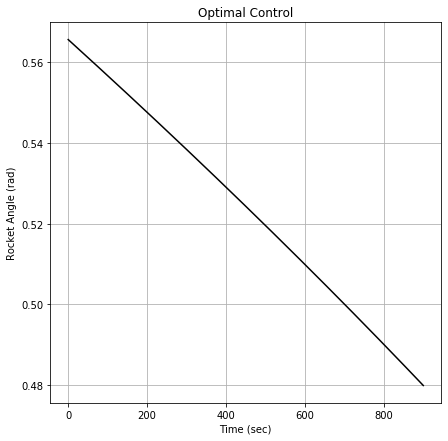

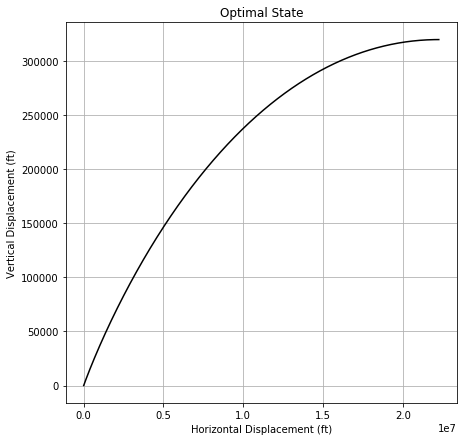

Final height = 319999.954 ft
Final upward speed = -0.0 ft/s
Optimal Cost = -49862.781


In [0]:
## Plot the Results:

# Individual states:
x1_vec = X_opt[0,:] # Horizontal displacement
x2_vec = X_opt[1,:] # Vertical displacement
x3_vec = X_opt[2,:] # Horizontal velocity
x4_vec = X_opt[3,:] # Vertical velocity

# Final states:
x1f = x1_vec[-1] # Final horizontal displacement
x2f = x2_vec[-1] # Final vertical displacement
x3f = x3_vec[-1] # Final horizontal velocity
x4f = x4_vec[-1] # Final vertical velocity

## Plot of the nominal control vs time:
fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(tvec, u_opt, '-', color = "black")
ax.set_title('Optimal Control')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Rocket Angle (rad)')
plt.grid()
plt.show()

# Plot of the nominal trajectory vs time:
fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(x1_vec, x2_vec, '-', color = "black")
ax.set_title('Optimal State')
ax.set_xlabel('Horizontal Displacement (ft)')
ax.set_ylabel('Vertical Displacement (ft)')
plt.grid()
plt.show()

# Print final height and speed:
print("Final height =", round(x2f,3), "ft")
print("Final upward speed =", round(x4f,3), "ft/s")
print("Optimal Cost =", -round(x3f,3))

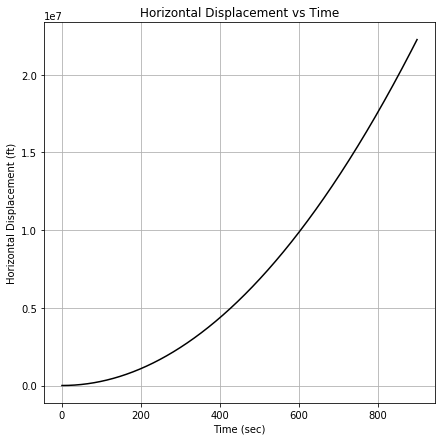

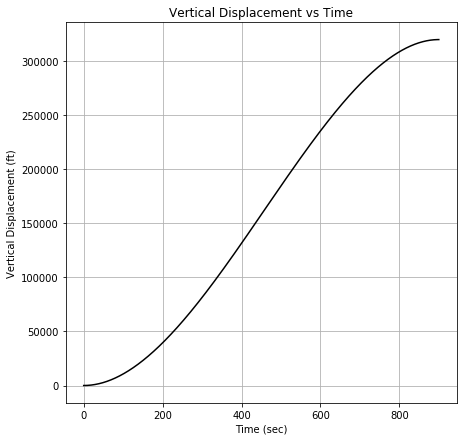

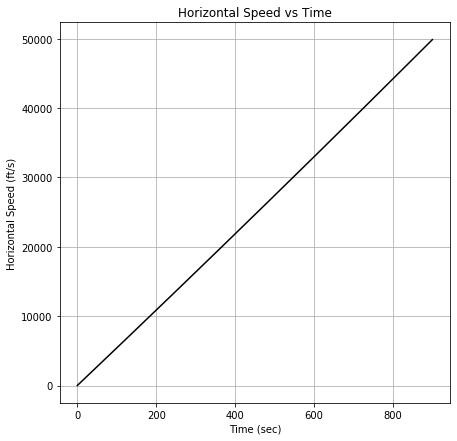

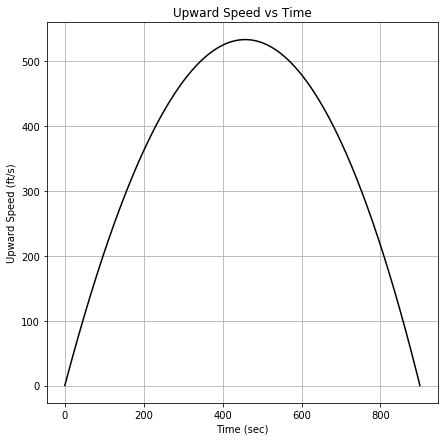

In [0]:
## Plotting individual states vs time:

## Plot of the horizontal displacement vs time:
fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(tvec, x1_vec, '-', color = "black")
ax.set_title('Horizontal Displacement vs Time')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Horizontal Displacement (ft)')
plt.grid()
plt.show()

## Plot of the vertical displacement vs time:
fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(tvec, x2_vec, '-', color = "black")
ax.set_title('Vertical Displacement vs Time')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Vertical Displacement (ft)')
plt.grid()
plt.show()

## Plot of the horizontal speed vs time:
fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(tvec, x3_vec, '-', color = "black")
ax.set_title('Horizontal Speed vs Time')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Horizontal Speed (ft/s)')
plt.grid()
plt.show()

## Plot of the upward speed vs time:
fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(tvec, x4_vec, '-', color = "black")
ax.set_title('Upward Speed vs Time')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Upward Speed (ft/s)')
plt.grid()
plt.show()